# Artificial Conversations

This notebook facilitates an interface to generate and proccess the artificial conversations - our dominant data modality.

### Import the Libraries

In [ ]:
# Import the required module for text 
from gtts import gTTS
import openai, os, random, json, random, time, tqdm
import numpy as np
from IPython.display import display, Markdown
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.playback import play
from pathlib import Path
from personal_settings import OPENAI_API_KEY

## Creating a New Artificial Conversation

In this section, we provide codes needed to generate a new artificial conversation. In order for the below codes to work, you have to place a valid OpenAI API key in to the `personal_settings.py` file.

### Generate the Conversation Script

Let's start by setting the important global variables. The only thing to do by your side is to set the `EPISODE` variable. 

In [ ]:
# Connection to OpenAI
client = openai.OpenAI(api_key=OPENAI_API_KEY)

#TODO: Set the ID/name of the episode
EPISODE = "A_Nice_Episode_Name_of_Your_Choice"

Now we generate the actual conversation script. The conversation will be a dialogue between two characters: Character A and Character B. The patient will repeat the lines said by Character A.

In order to do so successfully, the following has to be set in the code:

1. In the variable `character_a_role`, specify who is the Character A (e.g. 'a CEO of a Moravian space company ZetorSpace')   
2. Rewrite the elements of `plots` variable to high-level outlines of individual parts of the artificial conversation.
3. Rewrite the beggining of the conversation in `script` to open the following conversation well and to provide ChatGPT with an illustrative example how the conversation should look like.
4. If you want the conversation to be inspired by a specific article, copy that article to `data/artificial_conversations/article_for_gpt.txt`.

In [ ]:
art_conv = "data/artificial_conversations"

#TODO Answer the following question: Character A is {character_a_role}
character_a_role = "just like every other Character A"

#TODO: Rewrite the list items below to high-level outlines of individual parts of the artificial conversation.
plots = [ "Character A and Character B discuss the Topic 1",
         "Character A and Character B discuss the Topic 2",
         "Character A and Character B discuss the Topic 3",
         "Character A and Character B discuss the Topic 4"
        ]

#TODO: Rewrite the beggining of the conversation to open the conversations on the topics above
script = """
Character A: Hi, B 

Character B: Hi, A 

Character A: I was thinking about Topic 1

Character B: I find Topic 1 fascinating.

Character A: So, let's discuss it!
"""

for plot in plots:

    
    prompt_dialogue = "\n".join(script.splitlines())[-10:]

    prompt = f"""Consider the following text:

    {open(os.path.join(os.getcwd(),f"{art_conv}/article_for_gpt.txt")).read()}

    Continue the provided dialogue of Character A and Character B (no other character) by at least 70 more lines where: {plot}
    Character A uses at most five words per sentence. Character B at most five.
    Character A is {character_a_role}.
    Keep the vocabulary simple. Take care of the correct Czech word order.
    
    Make sure to stick to the line format: '<speaker_name>:<content>'

    {prompt_dialogue}

    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # Using GPT-4 model for conversation
        messages=[
            
            {"role": "user", "content": prompt}
        ]
    )
    new_content = response.choices[0].message.content
    script += "\n" + new_content
print(script)

The code above will result into a script draft. This draft might be however flawed. Namely, the Characters A and B might not alternate regulary. I.e. it may happen, that two consecutive lines are both attributed to Character A.

Copy the generated script to the raw text cell below and make sure to fix the segments, where the order is broken. Then copy the fixed text to the `script` variable.  

As mentioned above, copy the fixed text to the `script` variable.

In [ ]:
script = """

"""

### Generate the Intro Song

Simply run the cell below to generate a song lyrics on the topic of the conversation script.

You can modify the `style` variable to exert more control on the lyrics style.

In [ ]:
# OPTIONAL: specify the style of the song
style = "what fits lyrics the best"

# Generate song lyrics
plots_combined = " ".join(plots)

prompt = f"""Write Czech lyrics of a song ({style}) on the following topic:

    {plots_combined}
    """

response = client.chat.completions.create(
    model="gpt-4o",  # Using GPT-4 model for conversation
    messages=[
        
        {"role": "user", "content": prompt}
    ]
)
lyrics = response.choices[0].message.content
print(lyrics)

Once generated, go to [Suno.ai](https://suno.com/), generate the song and then download it to folder `data/artificial_conversations/songs`. The song has to be named `{EPISODE}.mp3`.

### Generate the Speech Drafts

Just run the code cells below. They will convert the text to speech.

The cell belows splits the script to lines said by Character A and lines said by Character B.

In [ ]:
# Split script to the lines said by Character A and to those said by Character B

character_a, character_b = [], []
tokenized_script = script.split()

current_line = ""
speaker = None
opinion_rate = 20
OPINON_SENTENCE = " Time for your personal comment:"

for t,token in enumerate(tokenized_script):
    if "Character A" in token:
        speaker = 0
        if current_line: 
            character_b.append(current_line)
            current_line = ""
    elif "Character B" in token:
        speaker = 1
        if current_line: 
            character_a.append(current_line)
            current_line = ""
    else: current_line += " " + token.replace("\n", "").replace("\"", "")
    if "Character B" in token and len(character_a) and not len(character_a)%20:
        character_b[-1] += f" {OPINON_SENTENCE}"

[character_a, character_b][speaker].append(current_line)

lines = {"character_a":character_a, "character_b":character_b}

The cell below uses Google Text-to-Speech (GTTS) to vocalize the lines by the both characters. 

In case your script contains words with irregular pronounciation that are vocalized incorrectly by GTTS, you can extend `speech_modifiers` list by `lambda` expressions that rewrite these problematic words such that regular pronounciation will vocalize them correctly. This change will not affect the transcriptions.

In [ ]:
# OPTIONAL: account for irregular pronounciation
speech_modifiers = [lambda line: line.replace("Musk", "Mask")]

# Generate 
for speaker in ["character_a", "character_b"]:  
    speaker_dir = os.path.join(os.getcwd(), f"data/artificial_conversations/{speaker}")
    for l,line in enumerate(lines[speaker]):
        for speech_mod in speech_modifiers: line = speech_mod(line)
        try:
            voice_segment = gTTS(text=line, lang="en", slow= False)
        except AssertionError:
            print(f"No text to speak: {line} (line {l})")
            raise AssertionError
        voice_segment.save(speaker_dir + f"/speech{l}.wav")


The following cell prepares the generated audio for voice conversion.

In [ ]:
def combine_mp3_files_with_silence(directory, f, output_path, name = "character_a"):
    # Create an empty AudioSegment object to hold the combined audio
    combined_audio = AudioSegment.empty()
    
    # Generate silence of f seconds
    silence_segment = AudioSegment.silent(duration=f * 1000)  # pydub works in milliseconds

    # Get all mp3 files in the directory, sorted by name
    mp3_files = sorted([file for file in os.listdir(directory) if file.endswith(".wav")], key=lambda line: int("".join([ch for ch in line if ch.isnumeric()])))[:len(lines[name])]

    # Load and combine the mp3 files with silence in between
    for m,mp3_file in enumerate(mp3_files):
        mp3_path = os.path.join(directory, mp3_file)
        audio_segment = AudioSegment.from_mp3(mp3_path)
        combined_audio += audio_segment + silence_segment

    # Export the combined audio to the output path
    combined_audio.export(f"{output_path}/{name}_combined.wav", format="wav") # Export for voice conversion
    if name == 'character_a': combined_audio.export(f"{output_path}/character_a_f'/character_a_f.wav", format="wav") # Export Character A as if it already underwent voice conversion

character_a_path = os.path.join(os.getcwd(),"data/artificial_conversations/character_a")
combine_mp3_files_with_silence(character_a_path, 1.5, "data/artificial_conversations/")
character_b_path = os.path.join(os.getcwd(),"data/artificial_conversations/character_b")
combine_mp3_files_with_silence(character_b_path, 1.5, "data/artificial_conversations/", "character_b")

### Voice Conversion

To make the voices distinctive, apply voice conversion to, at least, the lines by Character B.

For this purpose use either one of the following services:
1. [Voice.ai](https://voice.ai/tools/voice-changer): a commercial service for deep-learning based voice conversion. It might require a paid account.
2. [Voicechanger](https://voicechanger.io/): a free online service that changes voice using traditional signal processing methods. 

Upload the file `data/artificial_conversations/character_b_combined.wav` to the service. Wait for the conversion to proceed and then download it to `data/artificial_conversations/character_b_f/character_b_f.wav`. If you wish, you can process the audio file for Character A analogically.

### Generate the Artificial Conversation!

In this subsection we finally put all the components together and generate the artificial conversation that can be sent to our client.

But first of all, we have to split the voice converted recordings.

In [ ]:
def split_mp3_on_silence(input_mp3_path, output_dir, silence_thresh=-50, silence_duration=500, numeric_offset = 0):

    # Load the mp3 file
    if input_mp3_path.endswith("wav"): audio = AudioSegment.from_wav(input_mp3_path)
    elif  input_mp3_path.endswith("mp3"): audio = AudioSegment.from_mp3(input_mp3_path)

    # Split on silence (0.5 seconds = 500ms) using silence threshold
    chunks = split_on_silence(
        audio, 
        min_silence_len=silence_duration,   # Minimum length of silence required to split
        silence_thresh=silence_thresh,      # Silence threshold (in dBFS)
        keep_silence=0                      # Don't include silence in output chunks
    )

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the non-silent chunks
    for i, chunk in enumerate(chunks):
        output_filename = os.path.join(output_dir, f"speech{numeric_offset + i}.mp3")
        chunk.export(output_filename, format="mp3")
        print(f"Saved: {output_filename}")

split_mp3_on_silence("data/artificial_conversations/character_a_f/character_a_f.wav", "data/artificial_conversations/character_a_o", silence_duration=1500)
split_mp3_on_silence("data/artificial_conversations/character_b_f/character_b_f.wav", "data/artificial_conversations/character_b_o", silence_duration=1500)


And finally, we generate:
1. The audio file, which can be sent to the patient. The file is stored in `data/artificial_conversations/episodes/{EPISODE}.wav`
2. The corresponding json file containing timestamps and transcriptions that will later help with parsin the recording. The file is stored in `data/artificial_conversations/episodes/{EPISODE}.json`

In [ ]:

def create_combined_audio(song_path, speaker1, speaker2, episode, first_is_first=True):
    prefix = os.path.join(os.getcwd(),"data/artificial_conversations")
    
    # Load the song file and take the first 90 seconds
    song = AudioSegment.from_mp3(f"{prefix}/{song_path}") - 6
    first_part = song[:90000].fade_out(5000)  # 90 seconds, fade out last 5 seconds

    # Load all speaker files from both directories
    speaker1_dir = f"{prefix}/{speaker1}_o"
    speaker1_files = sorted([os.path.join(speaker1_dir, f) for f in os.listdir(speaker1_dir) if f.endswith('.mp3')], key=lambda line: int("".join([ch for ch in line if ch.isnumeric()])))[:len(lines[speaker1])]
    speaker2_dir = f"{prefix}/{speaker2}_o"
    speaker2_files = sorted([os.path.join(speaker2_dir, f) for f in os.listdir(speaker2_dir) if f.endswith('.mp3')], key=lambda line: int("".join([ch for ch in line if ch.isnumeric()])))[:len(lines[speaker2])]

    # Combine files alternately (starting with speaker1 or speaker2 depending on first_is_first)
    combined_audio = first_part
    silence_segment = AudioSegment.silent(duration=23000)  # 10 seconds of silence
    short_silence_segment = AudioSegment.silent(duration=1000)

    # OPTIONAL: Create your own instructions file
    intro = AudioSegment.from_wav(f"{prefix}/intro/intro.wav")
    # Uncomment if you need to turn up the instructions audio: intro += 15
    combined_audio += intro + short_silence_segment

    # Alternating between speaker1 and speaker2 files
    files_to_add = []
    for s1, s2 in zip(speaker1_files, speaker2_files):
        files_to_add += [s1, s2] if first_is_first else [s2, s1]
    
    # Handle case where one speaker directory has more files than the other
    if len(speaker1_files) > len(speaker2_files):
        files_to_add += speaker1_files[len(speaker2_files):]
    elif len(speaker2_files) > len(speaker1_files):
        files_to_add += speaker2_files[len(speaker1_files):]


    # Append alternating speaker files to the combined audio
    segments_to_parse, offset = [], None
    for i, file_path in enumerate(files_to_add):
        speaker_audio = AudioSegment.from_mp3(file_path)
        combined_audio += speaker_audio
        # Add silence after all speaker1's files
        if (int(first_is_first) + i)  % 2:  
            before = 0 if offset is None else len(combined_audio) - offset
            if offset is None: offset = len(combined_audio)
            combined_audio += silence_segment
            after = len(combined_audio) - offset
            segments_to_parse.append([before, after, character_a[i//2]])
        else: 
            combined_audio += short_silence_segment
            # Add silence for Jasmi to speak
            if OPINON_SENTENCE in character_b[i//2]:
                combined_audio += silence_segment

    
    # Append the last minute of the song with fade-in applied to the first 10 seconds
    last_minute = song[-60000:].fade_in(10000)  # Last 60 seconds with fade in on first 10 seconds
    combined_audio += last_minute

    # Save the combined audio to output path
    
    output_path = f"{prefix}/episodes/{episode}.mp3"
    combined_audio.export(output_path, format="mp3")
    print(f"Combined audio saved at {output_path}")
    
    return offset, segments_to_parse, combined_audio

# Create the audio
offset, segments_to_parse, combined_audio = create_combined_audio(f"/songs/{EPISODE}.mp3", "character_a", "character_b", EPISODE, first_is_first=True)

# Save the timestamp file that will later help us with parsing
prefix = os.path.join(os.getcwd(),"data/artificial_conversations")
open(f"{prefix}/episodes/{EPISODE}.json","w").write(json.dumps([offset, segments_to_parse]))

Combined audio saved at c:\Users\42073\Documents\David\JKU\Jasminka\Jasminka\data/artificial_conversations/episodes/Zatmeni_Slunce.mp3


## Annotate the Recording

This section facilitates an interface to turn audio recorded during the sessions into annotated audio segments. Before running it successfully, make sure to:
1. Place the audio into the path `data/raw`.
2. If the recording is in video format, run `python data_processing split_modalities.py` in the main directory of this repository.

The first cell loads the recording as well as the json file with transcriptions and timestamps. To run it successfully you have to:
1. Set `rec_path` to the location of the separated audio file.
2. Set `parse_path` to the location of the JSON file with timestamps and transcriptions.
3. Replace the undefined variable `undefined_offset` with the timestamp (in seconds) of the first line said by the patient in the recording

In [ ]:
from data_processing.create_dataset import LabelingProcedure, save_labels

def load_audio_segments(audio_file, json_file, offset):
    # Load the audio file as a pydub AudioSegment
    audio = AudioSegment.from_file(audio_file)
    
    # Load and parse the JSON file
    with open(json_file, 'r') as f:
        parse_info = json.load(f)
    
    # Get the segments info from parse_info[1]
    segments_info = parse_info[1]
    
    # Initialize lists for storing the sub-segments and labels
    segments = []
    labels = []
    
    # Process each segment
    for seg_start, seg_end, seg_label in segments_info:
        # Extract the sub-segment with the given offset
        sub_segment = [offset + seg_start, offset + seg_end]
        segments.append(sub_segment)
        labels.append(seg_label)
    
    # Return the list of audio segments and corresponding labels
    return audio, segments, labels

prefix = os.path.join(os.getcwd(),"data/artificial_conversations")
# TODO: Set the path to the audio recording
rec_path =  os.path.join(os.getcwd(), "data/audio", "Name_of_the_Audio_Recording.mp3")
# TODO: Set the path to the JSON file with the information about transcription and temporal coordinate of the segments
parse_path = f"{prefix}/episodes/Name_of_the_Episode.json"
# TODO: Change the undefined_offset to the timepoint (in seconds) when the patient says the first line int the audio recording  
offset = 1000 * undefined_offset
audio, segments, labels = load_audio_segments(rec_path, parse_path, offset)

# OPTIONAL: If you want to cut the 10s silent segments either from the beggiging (segment[0]) or the end (segment[1]) of the audio, adjust the parameters below:
for s, segment in enumerate(segments): 
    segment[0] -= 0
    segment[1]  -= 0
labelling = LabelingProcedure(labels, segments, audio, autoplay=False)

By running the following cell, you start the labelling procedure itself. An input window will pop up and you will have to type in  text commands control cropping/extending/retranscribing or commiting the segments.

For the details on how the commands work, read [this file](data_processing/pairing_language.md). 

Text:  Ano, jdeme na to!
86.0 correspond to 1 second


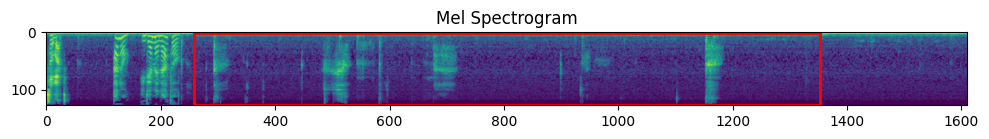

Commited


In [12]:
dataset = labelling.add_labels()

If you realized, during labelling the recording, that timestamps should be realingned with recording. You can  use the code below. Change `atok[0]` to readjust the beggining of the segments and `atok[1]` to readjust their end.

In [ ]:
# OPTIONAL: Realign the saved timestemps with the recording
for atok in labelling.audio_tokens: 
    atok[0] -= 0000
    atok[1] -= 2000

Finally, save the recording into a csv file. Make sure to set a unique name to the annotation file.

In [ ]:
print(f"Saving {len(labelling.comitted_pairs)} pairs")
# TODO: Set the name of the csv file where the annotations are stored
path = os.path.join(os.getcwd(), "data/annotations/EPISODE_XYZ.csv")
save_labels(path, dataset)

Saving 37 pairs
CSV written successfully to c:\Users\42073\Documents\David\JKU\Jasminka\Jasminka\data/annotations/110.csv
